# Corpus Analysis: CoDraw and CoDraw-iCR (v1)

In this notebook, we generate the descriptive statistics and figures for the EACL 2023 paper. 

In [1]:
import sys
sys.path.append('..')

In [2]:
import string
from collections import Counter

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from scipy import stats
from sklearn.metrics import cohen_kappa_score
from wordcloud import WordCloud

from icr.structs.game import Game

In [3]:
scipy.__version__

'1.10.0'

In [4]:
sns.set_style("darkgrid")

In [5]:
CODRAW_PATH = '../data/CoDraw-master/dataset/CoDraw_1_0.json'
ANNOTATION_PATH = '../data/cr_anno_adjudication/data_adju.tsv'

COLUMN_NAME = 'is CR? v2'

SPLITS = ('train', 'val', 'test')
INCLUDE_PEEK = True

In [6]:
with open(CODRAW_PATH, 'r') as f:
    codraw = json.load(f)
    
annotated = pd.read_csv(ANNOTATION_PATH, sep='\t')

***WARNING***: Here we select which annotator to use!

In [7]:
icr_types = set([sent for sent, label in zip(annotated['drawer\'s utterance'], annotated[COLUMN_NAME]) if label == 1])
non_icr_types = set([sent for sent, label in zip(annotated['drawer\'s utterance'], annotated[COLUMN_NAME]) if label == 0])

In [8]:
len(icr_types)

7712

In [9]:
len(non_icr_types)

6015

***WARNING***: Here we select whether to consider full dialogues or only until the peek action!

In [10]:
games = {name: Game(name, game, icr_types, include_peek=INCLUDE_PEEK) for name, game in codraw['data'].items()}

## Section 4: CoDraw and CoDraw-iCR descriptive statistics

Number of dialogues in each split:

In [11]:
size_splits = Counter([name.split('_')[0] for name in codraw['data'].keys()])
print(f'dialogues & {size_splits["train"]} & {size_splits["val"]} & {size_splits["test"]} \\\\')

dialogues & 7989 & 1002 & 1002 \\


Number of dialogues with peek action in each split:

In [12]:
def has_peek(dataseq):
    for turn in dataseq['dialog']:
        if 'peeked' in turn:
            return True
    return False

size_splits_with_peek = Counter([name.split('_')[0] 
                                 for name, dataseq in codraw['data'].items() 
                                 if has_peek(dataseq)])

print(f'\\hspace{{0.1cm}} with peek  & {size_splits_with_peek["train"]} & {size_splits_with_peek["val"]} & {size_splits_with_peek["test"]} \\\\')

\hspace{0.1cm} with peek  & 7315 & 923 & 913 \\


Average number of rounds per dialogue:

In [13]:
avr_rounds = {split: np.mean([len(dataseq['dialog']) for name, dataseq in codraw['data'].items() if split in name])
              for split in SPLITS}

print(f'avr. rounds/dialogue & {avr_rounds["train"]:.3f} & {avr_rounds["val"]:.3f} & {avr_rounds["test"]:.3f} \\\\')

avr. rounds/dialogue & 7.769 & 7.699 & 7.706 \\


Average number of tokens in teller's utterances: 

In [14]:
avr_teller_len = {split: np.mean([len(turn['msg_t'].split()) 
                                for name, dataseq in codraw['data'].items() for turn in dataseq['dialog']
                                if split in name])
                 for split in SPLITS}

print(f'avr. utterance len teller & {avr_teller_len["train"]:.3f} & {avr_teller_len["val"]:.3f} & {avr_teller_len["test"]:.3f} \\\\')

avr. utterance len teller & 14.364 & 14.480 & 14.316 \\


Average number of tokens in drawer's utterances:

In [15]:
avr_drawer_len = {split: np.mean([len(turn['msg_d'].split()) 
                                for name, dataseq in codraw['data'].items() for turn in dataseq['dialog']
                                if split in name])
                 for split in SPLITS}

print(f'avr. utterance len drawer & {avr_drawer_len["train"]:.3f} & {avr_drawer_len["val"]:.3f} & {avr_drawer_len["test"]:.3f} \\\\')

avr. utterance len drawer & 2.581 & 2.674 & 2.583 \\


Average final score:

In [16]:
avr_final_score = {split: np.mean([game.scores[-1]
                                   for name, game in games.items() if split in name])
                          for split in SPLITS}

print(f'avr. final score & {avr_final_score["train"]:.3f} & {avr_final_score["val"]:.3f} & {avr_final_score["test"]:.3f} \\\\')

avr. final score & 4.205 & 4.197 & 4.174 \\


Average final score before peek:

In [17]:
avr_atpeek_score = {split: np.mean([game.scores[game.peek_turn-1] if game.peek_turn is not None else game.scores[-1]
                                    for name, game in games.items() if split in name])
                          for split in SPLITS}

print(f'avr. final score before peek & {avr_atpeek_score["train"]:.3f} & {avr_atpeek_score["val"]:.3f} & {avr_atpeek_score["test"]:.3f} \\\\')

avr. final score before peek & 3.971 & 3.953 & 3.966 \\


Vocabulary size of the teller:


In [18]:
vocab_teller = Counter()

for game in games.values():
    for utterance in game.dialogue.teller_turns:
        vocab_teller.update(utterance.split())
print(f'vocab size \\textit{{IG}} & \multicolumn{{3}}{{c}}{{{len(vocab_teller)}}} \\\\')

vocab size \textit{IG} & \multicolumn{3}{c}{4506} \\


Vocabulary size of the drawer:

In [19]:
vocab_drawer = Counter()

for game in games.values():
    for utterance in game.dialogue.drawer_turns:
        vocab_drawer.update(utterance.split())
print(f'vocab size \\textit{{IF}} & \multicolumn{{3}}{{c}}{{{len(vocab_drawer)}}} \\\\')

vocab size \textit{IF} & \multicolumn{3}{c}{2200} \\


## Section 5: Analysis of CoDraw-iCR (v1)

Inter-Annotator Agreement between the first and the second (more trained) annotators:

In [20]:
annot1 = annotated['is CR?']
agrees = annotated['agree?']
annot2 = annotated['is CR? v2']

print(f'Raw agreement: {100 * np.mean(annot1 == annot2):.3f}%')
print(f'Sanity-check: {100 * sum(agrees) / len(agrees):.3f}%\n')

print(f'Cohen\'s kappa: {cohen_kappa_score(annot1, annot2)}')

Raw agreement: 96.452%
Sanity-check: 96.452%

Cohen's kappa: 0.9281002052726782


% of disagreements:

In [21]:
100 - (100 * np.mean(annot1 == annot2))

3.5477526043563756

% of hapax legomena among drawer's utterances:

In [22]:
types_drawer_utterances = Counter(utterance for game in games.values() for utterance in game.dialogue.drawer_turns)
n_hapax_legomena = len([utt for utt, n in types_drawer_utterances.items() if n == 1])
perc = 100 * n_hapax_legomena / len(types_drawer_utterances)

print(f'Number of types of drawer utterances: {len(types_drawer_utterances)}')
print(f'Number of types of drawer utterances that occur just once: {n_hapax_legomena} ({perc:.3f}%)')

Number of types of drawer utterances: 13727
Number of types of drawer utterances that occur just once: 12214 (88.978%)


% of the dialogues without iCRs:

In [23]:
games_without_icrs = sum([1 for game in games.values() if not game.dialogue.icr_turns])
print(f'{100*games_without_icrs / len(games):.3f}% of the games contain no iCRs.')

59.452% of the games contain no iCRs.


In [24]:
n_rounds = sum([game.n_turns for game in games.values()])
n_rounds_icr_dialogues = sum([game.n_turns for game in games.values() if game.dialogue.icr_turns])
# game.peek_turn is the turn after which the peek action occurs, which is the same as the number of turns before 
# the peek since turns are numbered from 0
n_rounds_until_peek = sum([game.peek_turn if game.peek_turn is not None else game.n_turns for game in games.values() ])

print(f'CoDraw has {n_rounds} rounds in total.')
print(f'Dialogues containing iCRs sum to {n_rounds_icr_dialogues} rounds in total.')
print(f'Dialogues (disregarding what happens after peeking) sum to {n_rounds_until_peek} rounds in total.')

CoDraw has 77502 rounds in total.
Dialogues containing iCRs sum to 36149 rounds in total.
Dialogues (disregarding what happens after peeking) sum to 61829 rounds in total.


Number and % of the drawer's utterances that are iCRs:

In [25]:
instances = [len(game.dialogue.icr_turns) for game in games.values()]

n_drawer_icr = sum(instances)
perc = 100*n_drawer_icr / n_rounds
print(f'{n_drawer_icr} out of {n_rounds} ({perc:.3f})% of the drawer\'s utterances are iCRs.')

mean_n_drawer_icr = np.mean(instances)
std_n_drawer_icr = np.std(instances)
print(f'Mean: {mean_n_drawer_icr} \t Std: {std_n_drawer_icr}')

8807 out of 77502 (11.364)% of the drawer's utterances are iCRs.
Mean: 0.8813169218452918 	 Std: 1.536547061023635


Number and % of iCR turns in dialogues containing at least one iCR:

In [26]:
instances = [len(game.dialogue.icr_turns) for game in games.values() if game.dialogue.icr_turns]

n_drawer_icr_with_icr = sum(instances)
perc_with_icr = 100 * n_drawer_icr_with_icr / n_rounds_icr_dialogues
print(f'{n_drawer_icr_with_icr} out of {n_rounds_icr_dialogues} ({perc_with_icr:.3f})% of the drawer\'s utterances are iCRs in dialogues that contain at least one iCR.')

mean_n_drawer_icr_with_icr = np.mean(instances)
std_n_drawer_icr_with_icr = np.std(instances)

print(f'Mean: {mean_n_drawer_icr_with_icr} \t Std: {std_n_drawer_icr_with_icr}')

8807 out of 36149 (24.363)% of the drawer's utterances are iCRs in dialogues that contain at least one iCR.
Mean: 2.1734945705824282 	 Std: 1.7361092562607838


In [73]:
instances = [game.dialogue.n_icrs_before_peek for game in games.values()]

n_drawer_icr_before_peek = sum(instances)
perc_before_peek = 100 * n_drawer_icr_before_peek / n_rounds_until_peek
print(f'{n_drawer_icr_before_peek} out of {n_rounds_until_peek} ({perc_before_peek:.3f})% of the drawer\'s utterances are iCRs in the turns before peek.')

mean_n_drawer_icr_before_peek = np.mean(instances)
std_n_drawer_icr_before_peek = np.std(instances)
print(f'Mean: {mean_n_drawer_icr_before_peek} \t Std: {std_n_drawer_icr_before_peek}')

7803 out of 61829 (12.620)% of the drawer's utterances are iCRs in the turns before peek.
Mean: 0.7808465926148304 	 Std: 1.363050233094586


### Table 2

- Number of dialogues (all and only with at least one iCR)
- Number of rounds (all dialogues and only those with at least one iCR)
- Mean and std iCRs per dialogue

In [28]:
table2 = pd.DataFrame(columns=['all', 'with iCRs', 'until peek'])

table2.loc['dialogues'] = [len(games), len(games) - games_without_icrs, '-']
table2.loc['rounds'] = [n_rounds, n_rounds_icr_dialogues, n_rounds_until_peek]
table2.loc['iCR utterances'] = [n_drawer_icr, n_drawer_icr_with_icr, n_drawer_icr_before_peek]
table2.loc['% iCR utterances'] = [perc, perc_with_icr, perc_before_peek]
table2.loc['mean iCRs/dialogue'] = [mean_n_drawer_icr, mean_n_drawer_icr_with_icr, mean_n_drawer_icr_before_peek]
table2.loc['std iCRs/dialogue'] = [std_n_drawer_icr, std_n_drawer_icr_with_icr, std_n_drawer_icr_before_peek]

In [29]:
table2

,all,with iCRs,until peek
dialogues,9993.000000,4052.000000,-
rounds,77502.000000,36149.000000,61829
iCR utterances,8807.000000,8807.000000,7803
% iCR utterances,11.363578,24.363053,12.620291
mean iCRs/dialogue,0.881317,2.173495,0.780847
std iCRs/dialogue,1.536547,1.736109,1.36305


In [30]:
print(table2.style.to_latex())

\begin{tabular}{lrrl}
 & all & with iCRs & until peek \\
dialogues & 9993.000000 & 4052.000000 & - \\
rounds & 77502.000000 & 36149.000000 & 61829 \\
iCR utterances & 8807.000000 & 8807.000000 & 7803 \\
% iCR utterances & 11.363578 & 24.363053 & 12.620291 \\
mean iCRs/dialogue & 0.881317 & 2.173495 & 0.780847 \\
std iCRs/dialogue & 1.536547 & 1.736109 & 1.363050 \\
\end{tabular}



### Figure 2: Utterance types

In [31]:
icr_types_freqs = Counter()

for game in games.values():
    types = np.array(game.dialogue.drawer_turns)[game.dialogue.icr_turns]
    icr_types_freqs.update(types)

n_icr_types = len(icr_types_freqs)
icr_hapax_leg = len([utt for utt, freq in icr_types_freqs.items() if freq == 1])
perc_hapax_leg = 100 * icr_hapax_leg / n_icr_types
print(f'CoDraw contains {n_icr_types} iCR types, of which {icr_hapax_leg} ({perc_hapax_leg:.3f}%) are hapay legomena.')

CoDraw contains 7712 iCR types, of which 7260 (94.139%) are hapay legomena.


/tmp/ipykernel_1945499/4025426346.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


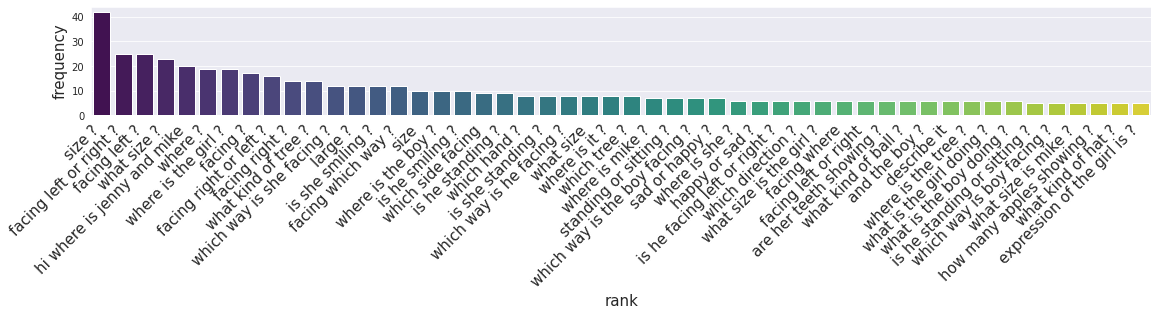

In [32]:
x, y = zip(*icr_types_freqs.most_common(50))

f, ax = plt.subplots(figsize=(19, 2))
sns.barplot(x=np.array(list(range(len(y)))), y=np.array(y), palette="viridis")
ax.set(xticklabels=x)
plt.xlabel('rank', fontsize=15)
plt.ylabel('frequency', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=15)
plt.tight_layout()
plt.savefig(f'./figures/zipf_includepeek={INCLUDE_PEEK}.pdf', bbox_inches='tight')
plt.show()


### Figure 3: Bigrams

In [33]:
init_bigrams_freqs = Counter()

for game in games.values():
    types = np.array(game.dialogue.drawer_turns)[game.dialogue.icr_turns]
    for utterance in types:
        # remove punctuation and ignore okay and ok at the beginning of the utterance
        words = utterance.translate(str.maketrans('', '', string.punctuation)).split()
        if words[0] in ('okay', 'ok'):
            words = words[1:]
        bigram = " ".join(words[:2])
    
        init_bigrams_freqs.update([bigram])

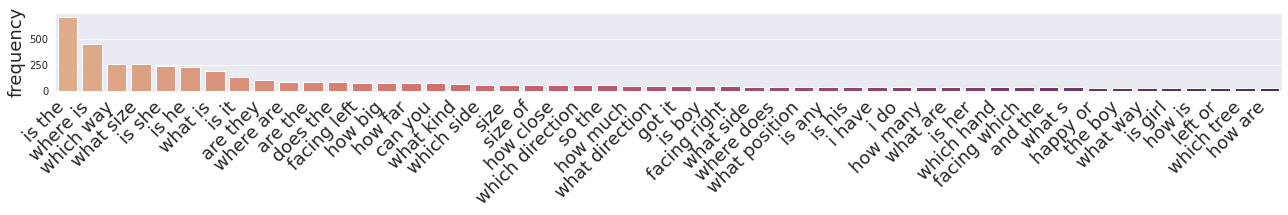

In [34]:
x, y = zip(*init_bigrams_freqs.most_common(50))

f, ax = plt.subplots(figsize=(18, 3))
sns.barplot(x=np.array(x), y=np.array(y), palette="flare", orient='v')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=18)
plt.ylabel('frequency', fontsize=18)
f.tight_layout()
plt.savefig(f'figures/ngram_freq_withpeek={INCLUDE_PEEK}.pdf', bbox_inches='tight')
plt.show()

### Figure 4: Wordclouds

In [35]:
icr_vocab = Counter()
other_vocab = Counter()

for game in games.values():
    for t, turn in enumerate(game.dialogue.drawer_turns):
        if t in game.dialogue.icr_turns:
            icr_vocab.update(turn.split())
        else:
            other_vocab.update(turn.split())

In [36]:
all_vocab = set(icr_vocab.keys()).union(set(other_vocab.keys()))

In [37]:
print(f'The drawer\'s vocab contain {len(all_vocab)} tokens, out of which {len(icr_vocab)} occur in iCRs.')

The drawer's vocab contain 2200 tokens, out of which 1468 occur in iCRs.


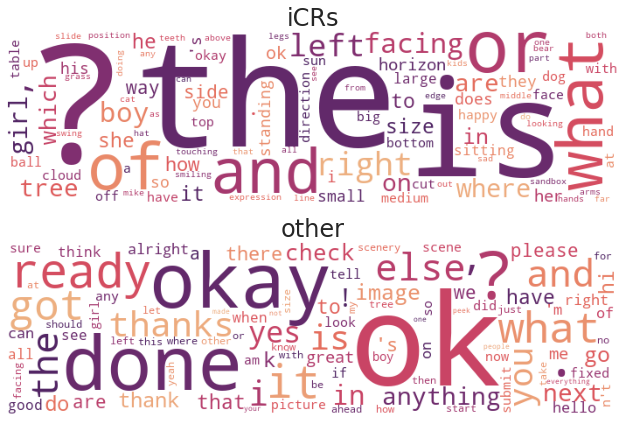

In [38]:
seed=5

fig, axes = plt.subplots(2, 1, figsize=(10,6))

token_freq = {token: freq for token, freq in icr_vocab.most_common(100)}
wordcloud = WordCloud(background_color='white', colormap='flare', random_state=seed, width=700)
wordcloud.generate_from_frequencies(frequencies=token_freq)
axes[0].imshow(wordcloud)
axes[0].set_title('iCRs', fontsize=24)
axes[0].axis("off")

token_freq = {token: freq for token, freq in other_vocab.most_common(100)}
wordcloud = WordCloud(background_color='white', colormap='flare', random_state=seed, width=700)
wordcloud.generate_from_frequencies(frequencies=token_freq)
axes[1].imshow(wordcloud)
axes[1].set_title('other', fontsize=24)
axes[1].axis("off")

fig.tight_layout()
#plt.savefig(f'figures/vocab_clouds_withpeek={INCLUDE_PEEK}.pdf', bbox_inches='tight')
plt.show()

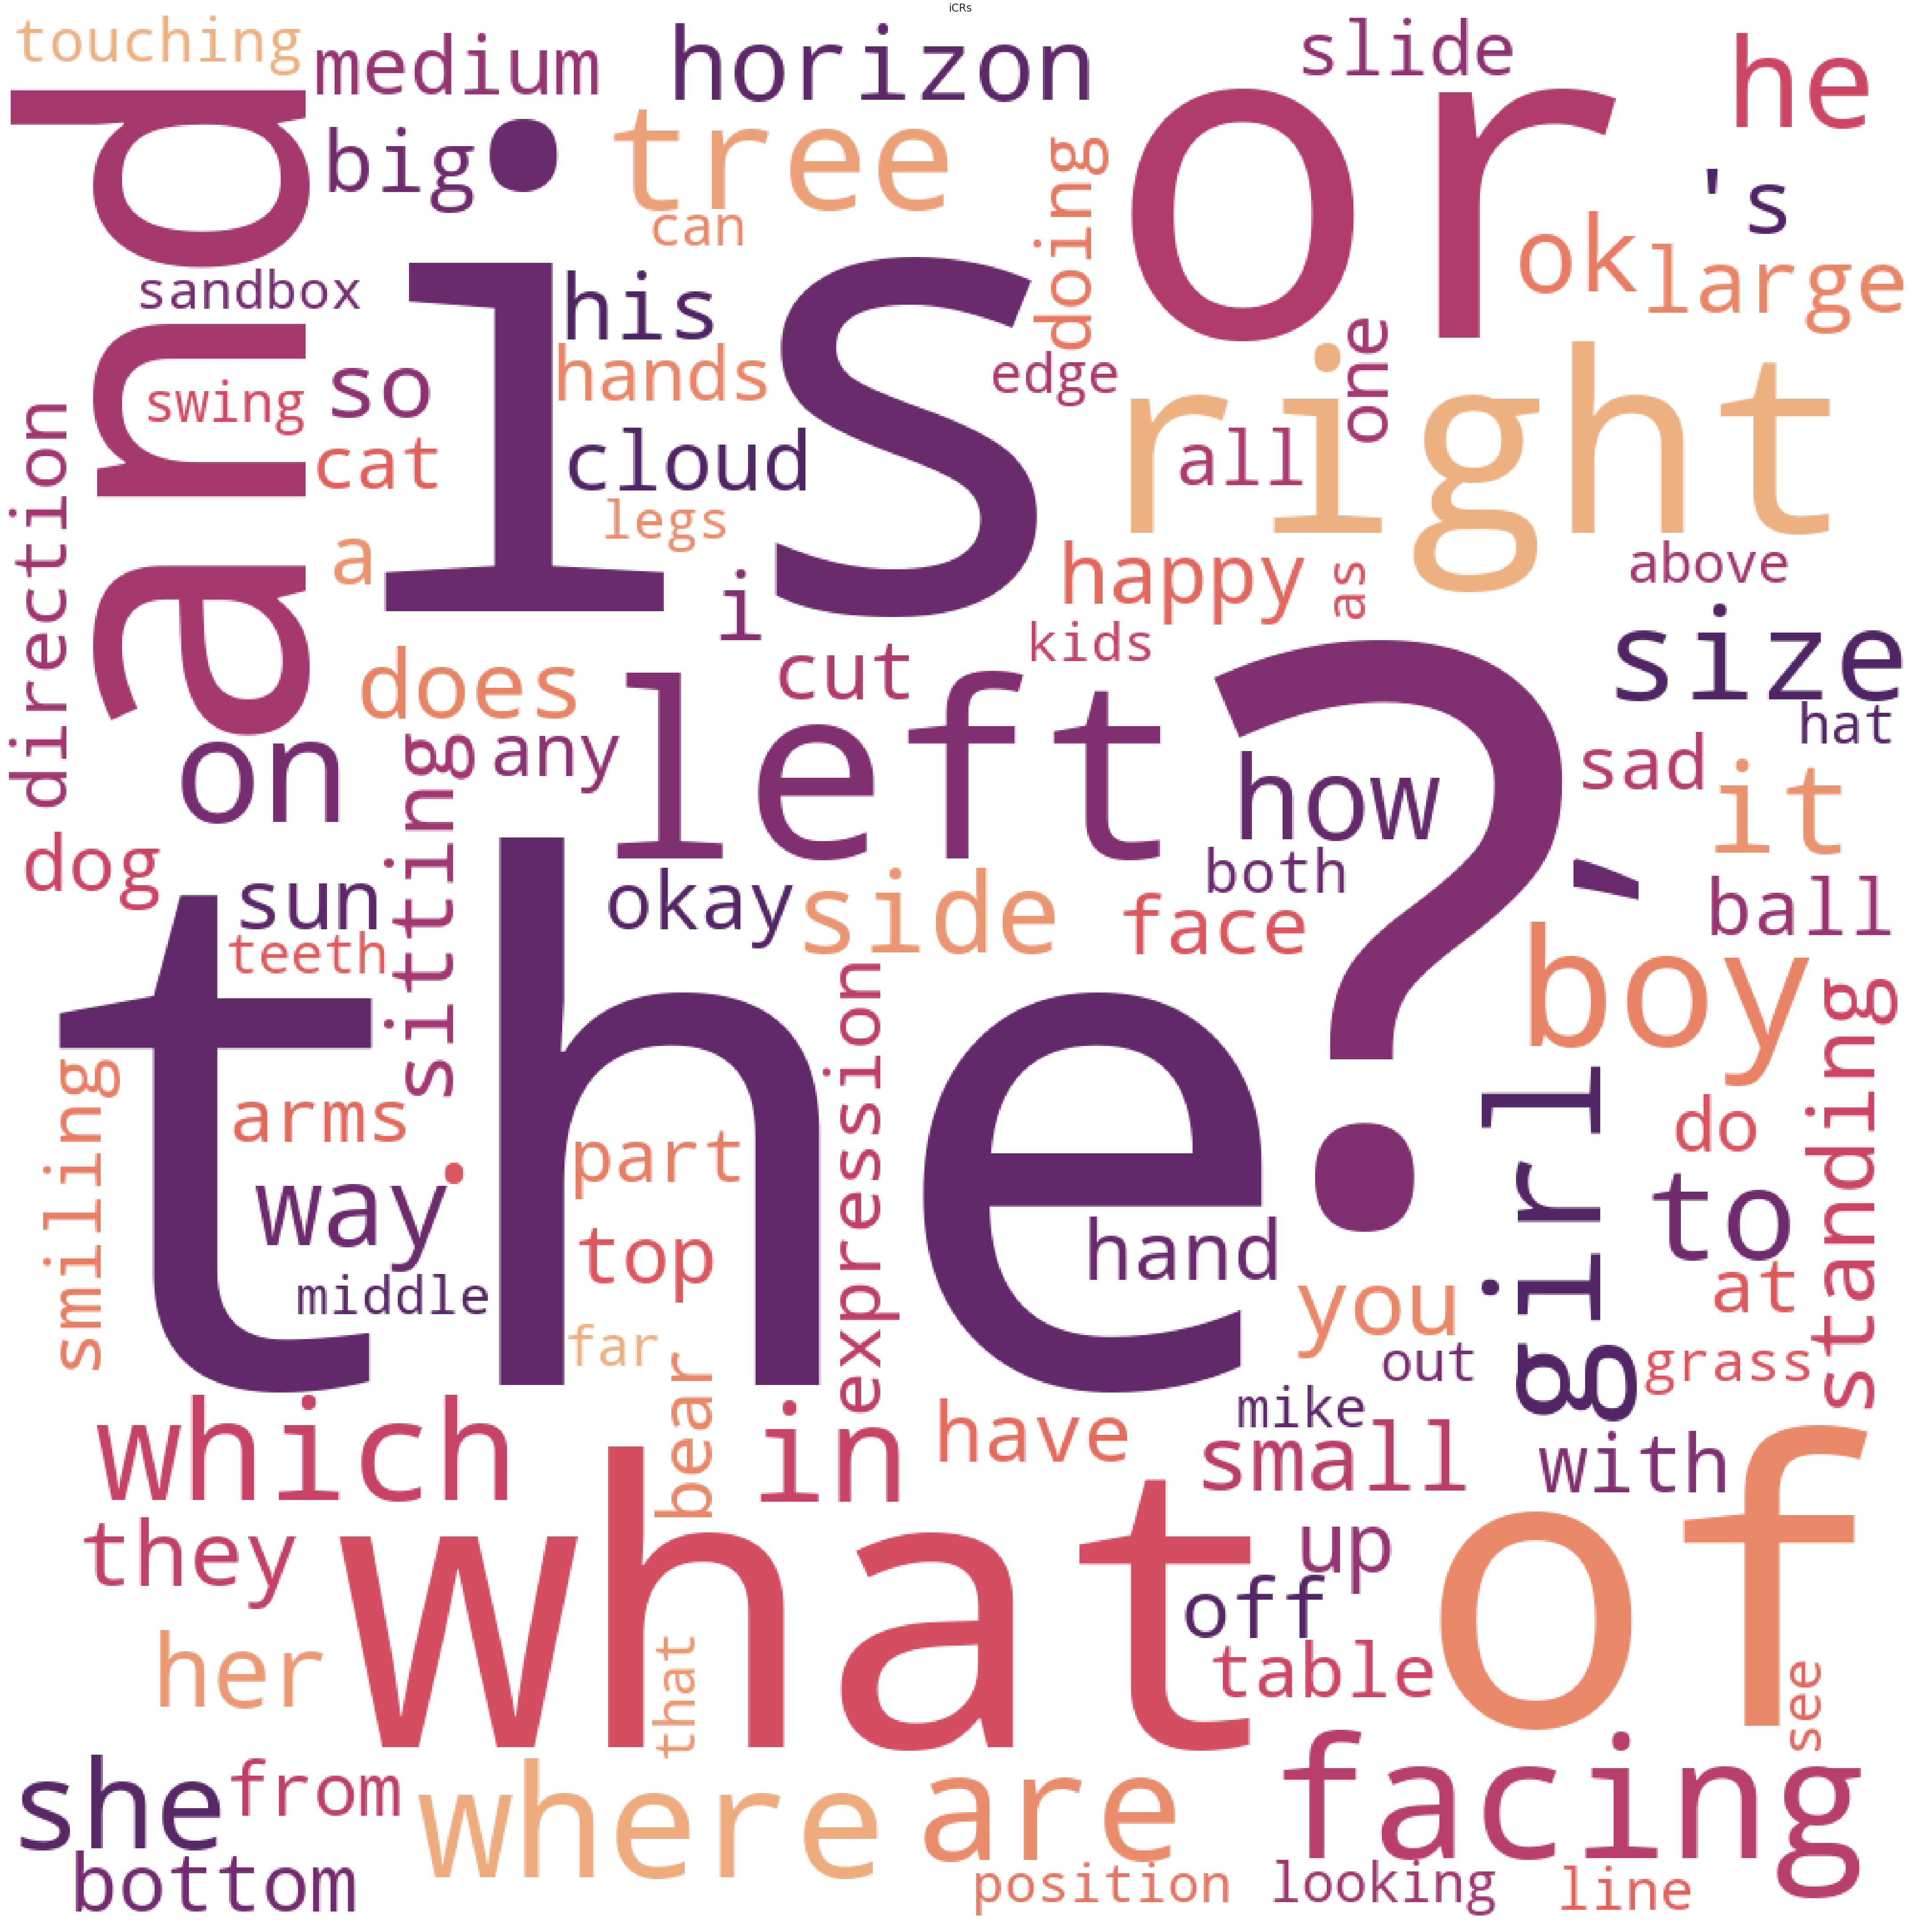

In [39]:
seed=5

fig, axes = plt.subplots(1, 1, figsize=(60,100))

token_freq = {token: freq for token, freq in icr_vocab.most_common(100)}
wordcloud = WordCloud(background_color='white', colormap='flare', random_state=seed, height=1000, width=1000)
wordcloud.generate_from_frequencies(frequencies=token_freq)
axes.imshow(wordcloud)
axes.set_title('iCRs', fontsize=24)
axes.axis("off")

fig.tight_layout()
plt.savefig(f'figures/vocab_clouds_icr_withpeek={INCLUDE_PEEK}.pdf', bbox_inches='tight')
plt.show()

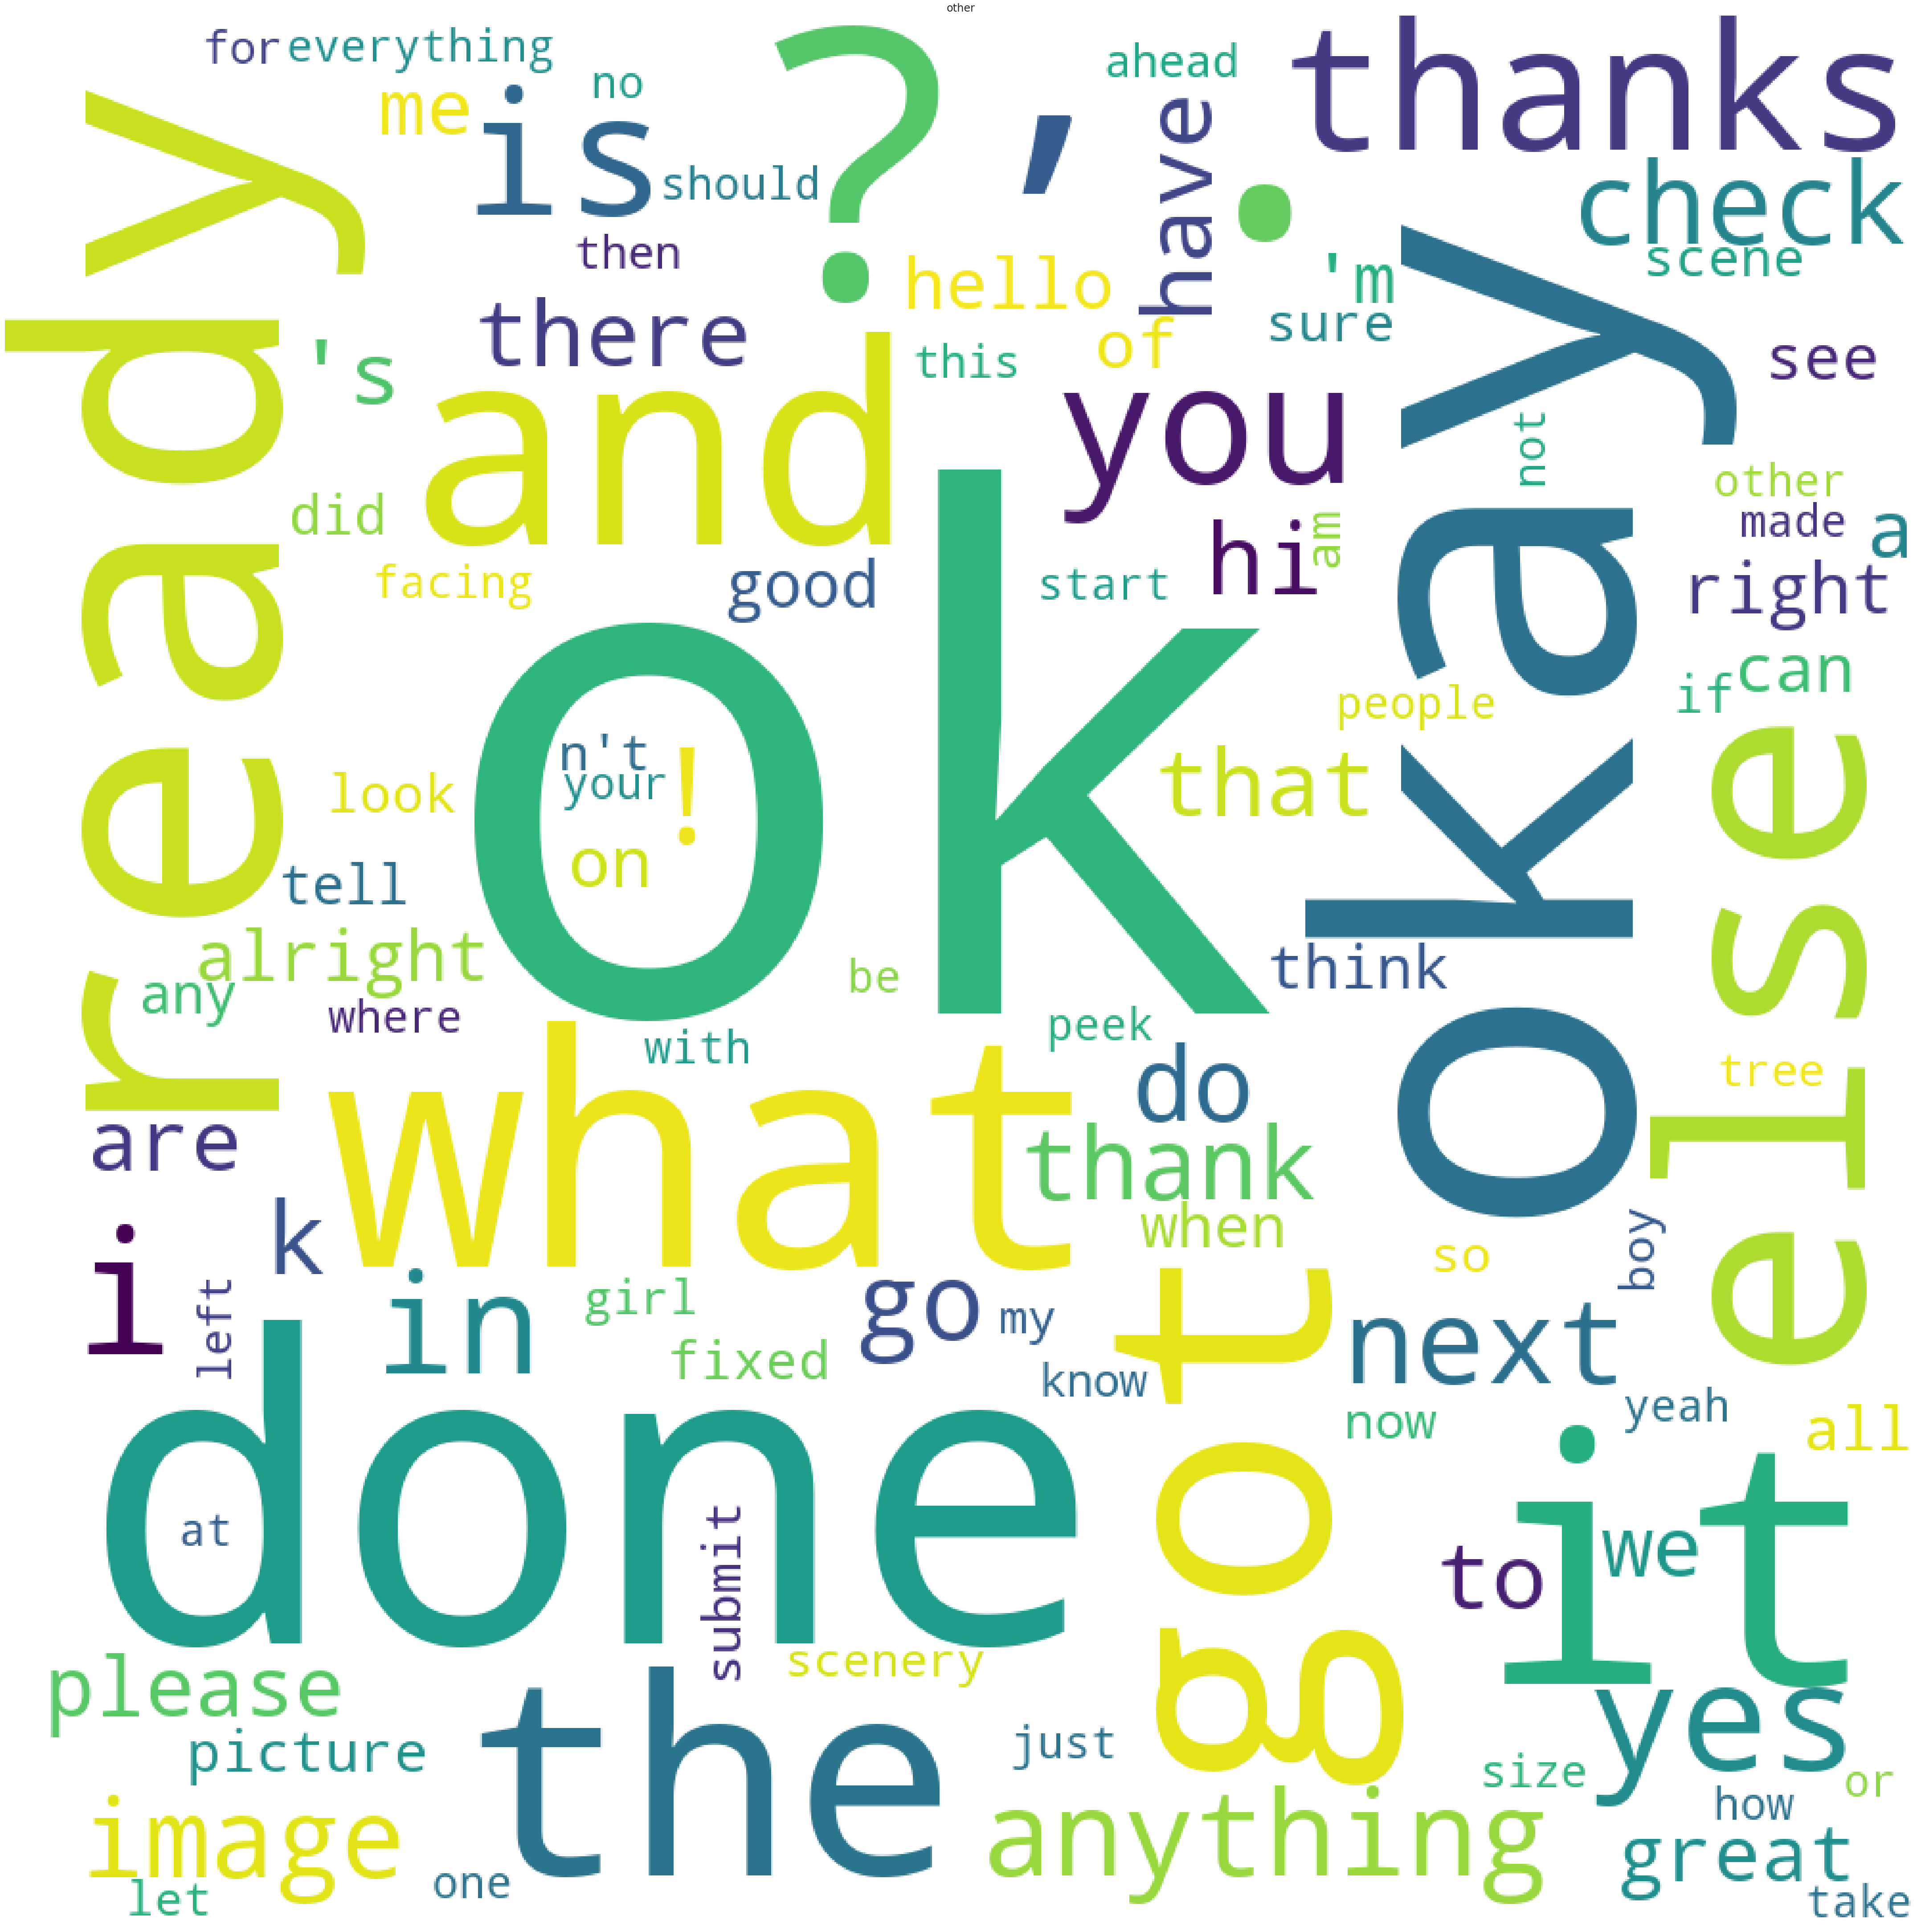

In [40]:
seed=5

fig, axes = plt.subplots(1, 1, figsize=(60,100))

token_freq = {token: freq for token, freq in other_vocab.most_common(100)}
wordcloud = WordCloud(background_color='white', colormap='viridis', random_state=seed, height=1000, width=1000)
wordcloud.generate_from_frequencies(frequencies=token_freq)
axes.imshow(wordcloud)
axes.set_title('other', fontsize=24)
axes.axis("off")

fig.tight_layout()
plt.savefig(f'figures/vocab_clouds_other_withpeek={INCLUDE_PEEK}.pdf', bbox_inches='tight')
plt.show()

### Table 3: Actions and Score Diffs

***WARNING***: we abuse the naming for the variables here and use 'response', however we do take into account whether a response indeed occurs. That will be part of the second round of corpus analysis with the fine-grained annotation. All we know is that these rounds immediately follow an iCR.

In [41]:
def get_number_actions_seqs(games):

    actions_per_round_icr = []
    actions_per_round_not_icr = []
    actions_per_round_response = []
    actions_per_round_not_response = []

    for game in games:
        n_actions = game.actions.n_actions_per_turn()
        for t in range(game.n_turns):
            n = n_actions[t]
            if t in game.dialogue.icr_turns:
                actions_per_round_icr.append(n)
            else:
                actions_per_round_not_icr.append(n)
            if t-1 in game.dialogue.icr_turns:
                actions_per_round_response.append(n)
            else:
                actions_per_round_not_response.append(n)
                
    return actions_per_round_icr, actions_per_round_not_icr, actions_per_round_response, actions_per_round_not_response

In [42]:
acts_icr, acts_not_icr, acts_response, acts_not_response = get_number_actions_seqs(games.values())

print(f'Mean actions per iCR round: {np.mean(acts_icr)}')
print(f'Mean actions per not iCR round: {np.mean(acts_not_icr)}')
print(f'Mean actions per post-iCR round: {np.mean(acts_response)}')
print(f'Mean actions per not post-iCR round: {np.mean(acts_not_response)}')

Mean actions per iCR round: 1.7262404905189055
Mean actions per not iCR round: 1.642361161656598
Mean actions per post-iCR round: 2.113748991586954
Mean actions per not post-iCR round: 1.593665092626226


In [43]:
games_with_icrs = [game for game in games.values() if game.dialogue.icr_turns]

acts_icr_with_icrs, acts_not_icr_with_icrs, acts_response_with_icrs, acts_not_response_with_icrs = get_number_actions_seqs(games_with_icrs)

print(f'Dialogues containing at least one iCR:')
print(f'Mean actions per iCR round: {np.mean(acts_icr_with_icrs)}')
print(f'Mean actions per not iCR round: {np.mean(acts_not_icr_with_icrs)}')
print(f'Mean actions per post-iCR round: {np.mean(acts_response_with_icrs)}')
print(f'Mean actions per not post-iCR round: {np.mean(acts_not_response_with_icrs)}')

Dialogues containing at least one iCR:
Mean actions per iCR round: 1.7262404905189055
Mean actions per not iCR round: 1.6234364713627387
Mean actions per post-iCR round: 2.113748991586954
Mean actions per not post-iCR round: 1.5015288293535236


In [44]:
table3 = pd.DataFrame(columns=['all', 'with iCRs'])

table3.loc['mean actions per round'] = ['', '']
table3.loc['   iCR rounds'] = [np.mean(acts_icr), np.mean(acts_icr_with_icrs)]
table3.loc['   not iCR rounds'] = [np.mean(acts_not_icr), np.mean(acts_not_icr_with_icrs)]
table3.loc['   post-iCR rounds'] = [np.mean(acts_response), np.mean(acts_response_with_icrs)]
table3.loc['   not post-iCR rounds'] = [np.mean(acts_not_response), np.mean(acts_not_response_with_icrs)]

In [45]:
table3

,all,with iCRs
mean actions per round,,
iCR rounds,1.72624,1.72624
not iCR rounds,1.642361,1.623436
post-iCR rounds,2.113749,2.113749
not post-iCR rounds,1.593665,1.501529


In [46]:
print(table3.style.to_latex())

\begin{tabular}{lll}
 & all & with iCRs \\
mean actions per round &  &  \\
   iCR rounds & 1.726240 & 1.726240 \\
   not iCR rounds & 1.642361 & 1.623436 \\
   post-iCR rounds & 2.113749 & 2.113749 \\
   not post-iCR rounds & 1.593665 & 1.501529 \\
\end{tabular}



In [47]:
def get_diffs(games):

    diffs_per_round_icr = []
    diffs_per_round_not_icr = []
    diffs_per_round_response = []
    diffs_per_round_not_response = []

    for game in games:
        for t in range(game.n_turns):
            diff = game.score_diffs[t]
            if t in game.dialogue.icr_turns:
                diffs_per_round_icr.append(diff)
            else:
                diffs_per_round_not_icr.append(diff)
            if t-1 in game.dialogue.icr_turns:
                diffs_per_round_response.append(diff)
            else:
                diffs_per_round_not_response.append(diff)
                
    return diffs_per_round_icr, diffs_per_round_not_icr, diffs_per_round_response, diffs_per_round_not_response

In [48]:
diffs_icr, diffs_not_icr, diffs_response, diffs_not_response = get_diffs(games.values())

print(f'Mean score diff at iCR round: {np.mean(diffs_icr)}')
print(f'Mean score diff at not iCR round: {np.mean(diffs_not_icr)}')
print(f'Mean score diff at post-iCR round: {np.mean(diffs_response)}')
print(f'Mean score diff at not post-iCR round: {np.mean(diffs_not_response)}')

Mean score diff at iCR round: 0.5927892687248275
Mean score diff at not iCR round: 0.5351264087480956
Mean score diff at post-iCR round: 0.537196452682995
Mean score diff at not post-iCR round: 0.5422440990727152


In [49]:
games_with_icrs = [game for game in games.values() if game.dialogue.icr_turns]

diffs_icr_with_icrs, diffs_not_icr_with_icrs, diffs_response_with_icrs, diffs_not_response_with_icrs = get_diffs(games_with_icrs)

print(f'Dialogues containing at least one iCR:')
print(f'Mean actions per iCR round: {np.mean(diffs_icr_with_icrs)}')
print(f'Mean actions per not iCR round: {np.mean(diffs_not_icr_with_icrs)}')
print(f'Mean actions per post-iCR round: {np.mean(diffs_response_with_icrs)}')
print(f'Mean actions per not post-iCR round: {np.mean(diffs_not_response_with_icrs)}')

Dialogues containing at least one iCR:
Mean actions per iCR round: 0.5927892687248275
Mean actions per not iCR round: 0.4310520848842352
Mean actions per post-iCR round: 0.537196452682995
Mean actions per not post-iCR round: 0.44937636774293704


In [50]:
table3.loc['mean score diff'] = ['', '']
table3.loc['    iCR rounds'] = [np.mean(diffs_icr), np.mean(diffs_icr_with_icrs)]
table3.loc['    non-iCR rounds'] = [np.mean(diffs_not_icr), np.mean(diffs_not_icr_with_icrs)]
table3.loc['    post-iCR rounds'] = [np.mean(diffs_response), np.mean(diffs_response_with_icrs)]
table3.loc['    not post-iCR rounds'] = [np.mean(diffs_not_response), np.mean(diffs_not_response_with_icrs)]

In [51]:
table3

,all,with iCRs
mean actions per round,,
iCR rounds,1.72624,1.72624
not iCR rounds,1.642361,1.623436
post-iCR rounds,2.113749,2.113749
not post-iCR rounds,1.593665,1.501529
mean score diff,,
iCR rounds,0.592789,0.592789
non-iCR rounds,0.535126,0.431052
post-iCR rounds,0.537196,0.537196
not post-iCR rounds,0.542244,0.449376


In [52]:
print(table3.style.to_latex())

\begin{tabular}{lll}
 & all & with iCRs \\
mean actions per round &  &  \\
   iCR rounds & 1.726240 & 1.726240 \\
   not iCR rounds & 1.642361 & 1.623436 \\
   post-iCR rounds & 2.113749 & 2.113749 \\
   not post-iCR rounds & 1.593665 & 1.501529 \\
mean score diff &  &  \\
    iCR rounds & 0.592789 & 0.592789 \\
    non-iCR rounds & 0.535126 & 0.431052 \\
    post-iCR rounds & 0.537196 & 0.537196 \\
    not post-iCR rounds & 0.542244 & 0.449376 \\
\end{tabular}



### Statistical significance testing

In [53]:
def diff_means(x, y):
    return np.mean(x) - np.mean(y)

def hyp_test(x, y, alternative, statistic, random_state=123):   
    return stats.permutation_test([x, y],
                                   alternative=alternative,
                                   statistic=statistic,
                                   permutation_type='independent',
                                   random_state=random_state)

Mean actions per round in non-iCR rounds is lower than in iCR rounds:

In [54]:
perm_test = hyp_test(acts_not_icr, acts_icr, 'less', diff_means)
print('Statistic: ', perm_test.statistic)
print('P-value for diff: ', perm_test.pvalue)

Statistic:  -0.08387932886230742
P-value for diff:  0.0001


In [55]:
perm_test = hyp_test(acts_not_icr_with_icrs, acts_icr_with_icrs,  'less', diff_means)
print('Statistic: ', perm_test.statistic)
print('P-value for diff: ', perm_test.pvalue)

Statistic:  -0.10280401915616677
P-value for diff:  0.0001


Mean actions per round in non-response rounds is lower than in response rounds:

In [56]:
perm_test = hyp_test(acts_not_response, acts_response, 'less', diff_means)
print('Statistic: ', perm_test.statistic)
print('P-value for diff: ', perm_test.pvalue)

Statistic:  -0.5200838989607282
P-value for diff:  0.0001


In [57]:
perm_test = hyp_test(acts_not_response_with_icrs, acts_response_with_icrs, 'less', diff_means)
print('Statistic: ', perm_test.statistic)
print('P-value for diff: ', perm_test.pvalue)

Statistic:  -0.6122201622334305
P-value for diff:  0.0001


Mean score diff per round in non-iCR rounds is lower than in iCR rounds:

In [58]:
perm_test = hyp_test(diffs_not_icr, diffs_icr, 'less', diff_means)
print('Statistic: ', perm_test.statistic)
print('P-value for diff: ', perm_test.pvalue)

Statistic:  -0.05766285997673193
P-value for diff:  0.0001


In [59]:
perm_test = hyp_test(diffs_not_icr_with_icrs, diffs_icr_with_icrs, 'less', diff_means)
print('Statistic: ', perm_test.statistic)
print('P-value for diff: ', perm_test.pvalue)

Statistic:  -0.16173718384059232
P-value for diff:  0.0001


Mean score diff per round in non-response rounds is lower than in response rounds:

In [60]:
perm_test = hyp_test(diffs_not_response, diffs_response, 'greater', diff_means)
print('Statistic: ', perm_test.statistic)
print('P-value for diff: ', perm_test.pvalue)

Statistic:  0.005047646389720217
P-value for diff:  0.244


In [61]:
perm_test = hyp_test(diffs_not_response_with_icrs, diffs_response_with_icrs, 'less', diff_means)
print('Statistic: ', perm_test.statistic)
print('P-value for diff: ', perm_test.pvalue)

Statistic:  -0.08782008494005794
P-value for diff:  0.0001


# Appendix

In [62]:
import random

A few non-icr utterances to be added as examples:

In [63]:
random.seed(9) # 3, 7, 8
random.choices(list(non_icr_types), k=20)

["i 'm ready when you are",
 "hello . i 'm ready .",
 'tjx',
 'sure thanks',
 'anything else ? please include everything you see .',
 'completed',
 'anything else in scene ?',
 'anything else in the pic ?',
 'hello what do we have',
 'all set . thanks',
 'and to answer first question ?',
 "let 's start with the sky . can you tell me about it ?",
 'okay cool',
 'i added jenny .',
 'i think we have it .',
 'k let me know if i need to change anything around',
 'next item',
 'so i can submit ?',
 'i only see a swing set',
 'ok what is next ?']

Distribution of iCRs by turns:

In [64]:
icrs_per_turn = Counter()
for game in games.values():
    icrs_per_turn.update(game.dialogue.icr_turns)

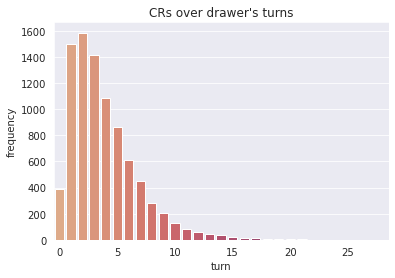

In [65]:
colors = sns.color_palette('deep')

turns, counts = zip(*icrs_per_turn.items())
sns.barplot(x=np.array(turns), y=np.array(counts), palette="flare")
plt.title('CRs over drawer\'s turns')
plt.xlabel('turn')
plt.ylabel('frequency')
plt.xticks(list(range(0, 30, 5)))
fig.tight_layout()
plt.savefig(f'figures/icr-vs-round-id_withpeek={INCLUDE_PEEK}.pdf', bbox_inches='tight')
plt.show()

Distribution of number of iCRs per dialogue:

In [66]:
n_icrs_per_dialogue = {name: game.dialogue.n_icrs for name, game in games.items()}

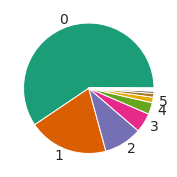

In [67]:
freqs = Counter(n_icrs_per_dialogue.values())

x, y = zip(*freqs.most_common(100))
plt.figure(figsize=(3,3))
colors = sns.color_palette("Dark2")
plt.pie(y, labels=[n if n < 6 else None for n in x], colors=colors, textprops={'fontsize': 14})
#plt.title('Number of clarification requests per dialogue')
fig.tight_layout()
plt.savefig(f'figures/n-icr-per-dialogue_withpeek={INCLUDE_PEEK}.pdf', bbox_inches='tight')
plt.show()

Dialogue length vs. number of iCRs in the dialogue:

In [68]:
len_vs_n_icr = [(game.n_turns, game.dialogue.n_icrs) for game in games.values()]

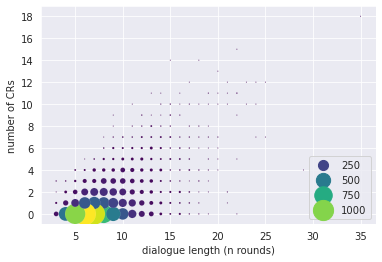

In [69]:
x, z = zip(*Counter(len_vs_n_icr).items())
x, y = zip(*x)

sns.scatterplot(x=x, y=y, hue=z, size=z, sizes=(1, 500), palette='viridis')
plt.xlabel('dialogue length (n rounds)')
plt.ylabel('number of CRs')
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.yticks(list(range(0, max(y)+1, 2)))
fig.tight_layout()
plt.legend(loc ='lower right')
plt.savefig(f'figures/icr-vs-rounds_withpeek={INCLUDE_PEEK}.pdf', bbox_inches='tight')
plt.show()

Overlap between splits:

In [70]:
types_by_split = {'train': Counter(), 'val': Counter(), 'test': Counter()}
types_val = Counter()
types_test = Counter()

for name, game in codraw['data'].items():
    split = name.split('_')[0]
    for t, turn in enumerate(game['dialog']):
        msg = turn['msg_d'] if turn['msg_d'] != '' else np.nan
        if msg in icr_types:
            types_by_split[split].update([msg])

In [71]:
overlap_train_val =  len(set(types_by_split['train'].keys()) & set(types_by_split['val'].keys()))
overlap_train_test =  len(set(types_by_split['train'].keys()) & set(types_by_split['test'].keys()))

perc_val_train = 100 * overlap_train_val / len(types_by_split["val"])
print(f'{perc_val_train:.2f}% of validation CR utterance types belong to train set. ')
perc_test_train = 100 * overlap_train_test / len(types_by_split["test"])
print(f'{perc_test_train:.2f}% of test CR utterance types belong to train set. ')

14.58% of validation CR utterance types belong to train set. 
11.96% of test CR utterance types belong to train set. 


In [72]:
overlap_train_val_freq = sum([count for sent, count in types_by_split['val'].items() if sent in types_by_split['train']])
overlap_train_test_freq = sum([count for sent, count in types_by_split['test'].items() if sent in types_by_split['train']])

perc_val_train = 100 * overlap_train_val_freq / sum(types_by_split["val"].values())
print(f'{perc_val_train:.2f}% of validation CR utterances belong to train set. ')
perc_test_train = 100 * overlap_train_test_freq / sum(types_by_split["test"].values())
print(f'{perc_test_train:.2f}% of test CR utterances belong to train set. ')

17.50% of validation CR utterances belong to train set. 
14.81% of test CR utterances belong to train set. 
